# Inicio

In [1]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from joblib import dump, load
import lightgbm


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
pd.options.display.max_columns = None

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!gdown 1Tpwb4eCDli98UOD8hdv8JKgKAMGAtCL0 -O pumps_cleaned.csv

Downloading...
From: https://drive.google.com/uc?id=1Tpwb4eCDli98UOD8hdv8JKgKAMGAtCL0
To: /content/pumps_cleaned.csv
100% 9.03M/9.03M [00:00<00:00, 114MB/s]


In [5]:
pumps_df=pd.read_csv("pumps_cleaned.csv")
pumps_df.head()

,id,longitude,latitude,region,extraction_type,management,payment_type,quality_group,quantity_group,source,waterpoint_type,status_group,population_imputed,altitud,construction_year_imputed,scheme_management_imputed,permit_imputed,gdp_per_capita
0,69572,34.938093,-9.856322,Iringa,gravity,vwc,annually,good,enough,spring,communal standpipe,functional,109.000000,1367.0,1999.0,VWC,False,4028.5
1,8776,34.698766,-2.147466,Mara,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional,280.000000,1440.0,2010.0,Other,True,2258.3
2,34310,37.460664,-3.821329,Manyara,gravity,vwc,per bucket,good,enough,dam,communal standpipe multiple,functional,250.000000,699.0,2009.0,VWC,True,2654.6
3,67743,38.486161,-11.155298,Mtwara,submersible,vwc,never pay,good,dry,machine dbh,communal standpipe multiple,non functional,58.000000,254.0,1986.0,VWC,True,2725.2
4,19728,31.130847,-1.825359,Kagera,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional,500.316472,1675.0,1996.0,Other,True,1168.7


In [9]:
pumps_df.shape
# pumps_df['source'].unique()

(57587, 18)

# Initial RandonForest

In [ ]:
X = pumps_df.drop(columns=['status_group','id']).copy()
y = pumps_df['status_group']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

categorical_features = X.select_dtypes(include=['object', 'category']).columns

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
print(X.shape)

(57587, 92)


In [ ]:
print(X.isnull().sum().sum())
print(y.isnull().sum().sum())

0
0


In [ ]:
rf_model = RandomForestClassifier(random_state=42)
# param_grid_rf = {
#     "n_estimators": [50, 100, 150, 200],
#     "max_depth" : [3, 4, 5, 6, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],
#     "class_weight": ["balanced", None],
#     "criterion": ["gini", "entropy"]
# }
param_grid_rf = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth" : [3, 4, 5, 6],
    'max_features': ['sqrt', 'log2'],
    "class_weight": ["balanced", None]
}

precision_weighted = make_scorer(precision_score, average='weighted')

grid_rf = GridSearchCV(estimator=rf_model,
                       param_grid=param_grid_rf,
                      #  scoring=["accuracy","precision", "recall", "f1"],
                       scoring=precision_weighted, cv=5, return_train_score=True,
                       verbose=1, n_jobs=-1)

grid_rf.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor modelo
print("Mejores parámetros encontrados:", grid_rf.best_params_)
rf_model = grid_rf.best_estimator_


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Mejores parámetros encontrados: {'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}
Exactitud train: 0.61
Exactitud test: 0.60


In [ ]:
# Evaluar el mejor modelo en el conjunto de prueba
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

print(f"Exactitud train: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"Exactitud test: {accuracy_score(y_test, y_pred_test):.2f}")

print("Train Classification Report:")
print(classification_report(y_train, y_pred_train, target_names=label_encoder.classes_))

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- permit_imputed
- scheme_management_imputed_Other
- scheme_management_imputed_Parastatal
- scheme_management_imputed_Private operator
- scheme_management_imputed_SWC
- ...
Feature names seen at fit time, yet now missing:
- imputed_permit
- imputed_scheme__management_Other
- imputed_scheme__management_Parastatal
- imputed_scheme__management_Private operator
- imputed_scheme__management_SWC
- ...


# Guardar modelo

In [ ]:
# ruta_modelo = '/content/drive/MyDrive/Maestria Andes/Applied data science/Proyecto DS 2024/Modelos/'
ruta_modelo = '/content/drive/MyDrive/Proyecto DS 2024/Modelos/'

In [ ]:
#Guardar modelo
dump(rf_model,f'{ruta_modelo}rf_model.joblib')

['/content/drive/MyDrive/Maestria Andes/Applied data science/Proyecto DS 2024/Data/rf_model.joblib']

In [ ]:
#Cargar modelo
rf_model = load(f'{ruta_modelo}rf_model.joblib')

In [ ]:
# Evaluar el modelo
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

print(f"Exactitud train: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"Exactitud test: {accuracy_score(y_test, y_pred_test):.2f}")

print("\nTrain Classification Report:")
print(classification_report(y_train, y_pred_train, target_names=label_encoder.classes_))

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- permit_imputed
- scheme_management_imputed_Other
- scheme_management_imputed_Parastatal
- scheme_management_imputed_Private operator
- scheme_management_imputed_SWC
- ...
Feature names seen at fit time, yet now missing:
- imputed_permit
- imputed_scheme__management_Other
- imputed_scheme__management_Parastatal
- imputed_scheme__management_Private operator
- imputed_scheme__management_SWC
- ...


# Improvement

In [ ]:
# Mostrar en un DataFrame
importance_df = pd.DataFrame({
    'Feature': rf_model.feature_names_in_,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
importance_df.head(10)

,Feature,Importance
81,waterpoint_type_other,0.095345
0,longitude,0.094363
33,extraction_type_other,0.077320
27,extraction_type_gravity,0.072668
64,quantity_group_enough,0.068920
4,construction_year_imputed,0.058838
6,gdp_per_capita,0.052084
72,source_river,0.031534
1,latitude,0.031353
3,altitud,0.030005


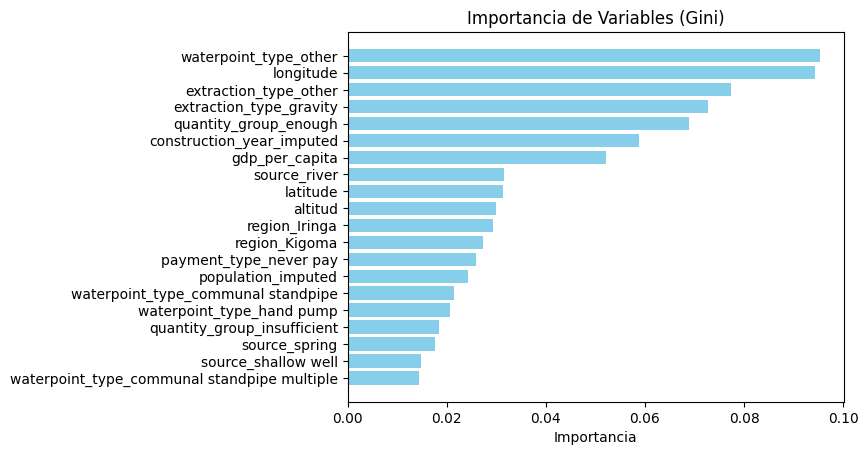

In [ ]:
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20), color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de Variables (Gini)')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
Top_features_start=importance_df['Feature'].apply(lambda x: x.split('_')[0]).drop_duplicates().head(10).tolist()
Top_features_start

['waterpoint',
 'longitude',
 'extraction',
 'quantity',
 'construction',
 'gdp',
 'source',
 'latitude',
 'altitud',
 'region']

In [ ]:
top_features=[i for i in pumps_df.columns.tolist() if i.split('_')[0] in Top_features_start]
top_features

['longitude',
 'latitude',
 'region',
 'extraction_type',
 'quantity_group',
 'source',
 'waterpoint_type',
 'altitud',
 'construction_year_imputed',
 'gdp_per_capita']

In [ ]:
X = pumps_df[top_features].copy()
y = pumps_df['status_group']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

categorical_features = X.select_dtypes(include=['object', 'category']).columns

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
print(X.shape)

(57587, 58)


In [ ]:
rf_model_1 = RandomForestClassifier(random_state=42)
# param_grid_rf = {
#     "n_estimators": [50, 100, 150, 200],
#     "max_depth" : [3, 4, 5, 6, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],
#     "class_weight": ["balanced", None],
#     "criterion": ["gini", "entropy"]
# }
param_grid_rf = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth" : [3, 4, 5, 6],
    'max_features': ['sqrt', 'log2'],
    "class_weight": ["balanced", None]
}

precision_weighted = make_scorer(precision_score, average='weighted')

grid_rf = GridSearchCV(estimator=rf_model_1,
                       param_grid=param_grid_rf,
                      #  scoring=["accuracy","precision", "recall", "f1"],
                       scoring=precision_weighted, cv=5, return_train_score=True,
                       verbose=1, n_jobs=-1)

grid_rf.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor modelo
print("Mejores parámetros encontrados:", grid_rf.best_params_)
rf_model_1 = grid_rf.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Mejores parámetros encontrados: {'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200}
Exactitud train: 0.59
Exactitud test: 0.59


In [ ]:
# Evaluar el mejor modelo en el conjunto de prueba
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

print(f"Exactitud train: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"Exactitud test: {accuracy_score(y_test, y_pred_test):.2f}")

print("\nTrain Classification Report:")
print(classification_report(y_train, y_pred_train, target_names=label_encoder.classes_))

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

Exactitud train: 0.59
Exactitud test: 0.59

Train Classification Report:
                         precision    recall  f1-score   support

             functional       0.76      0.61      0.68     21999
functional needs repair       0.16      0.61      0.25      2741
         non functional       0.72      0.56      0.63     15570

               accuracy                           0.59     40310
              macro avg       0.55      0.59      0.52     40310
           weighted avg       0.71      0.59      0.63     40310

Test Classification Report:
                         precision    recall  f1-score   support

             functional       0.76      0.61      0.68      9390
functional needs repair       0.16      0.61      0.25      1190
         non functional       0.73      0.56      0.63      6697

               accuracy                           0.59     17277
              macro avg       0.55      0.59      0.52     17277
           weighted avg       0.71      0.59     

# End